# SmartBeds - Manifolds

## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [2]:
%matplotlib inline 
#para dibujar en el propio notebook
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #%matplotlilib.pyplot como plt
import mpl_toolkits.mplot3d #Matplotlib 3d
import pickle as pk #Pikcle as pk
import gc #Garbage colector
from sys import getsizeof

## Lectura de datos

In [3]:
with open('datos.pdd','rb') as f:
    datos = pk.load(f)
    
datos_seizure = datos.loc[datos['target']==True]
datos_notSeizure = datos.loc[datos['target']==False]
getsizeof(datos)/2**20,getsizeof(datos_seizure)/2**20,getsizeof(datos_notSeizure)/2**20

(298.4304943084717, 0.1861133575439453, 298.2444038391113)

In [15]:
with open('datosE.pdd','rb') as f:
    dataE = pk.load(f)

dataE_seizure = dataE.loc[dataE['target']==True]
dataE_notSeizure = dataE.loc[dataE['target']==False]

## Particionado - Solo día de crisis

In [4]:
### Días donde hubo crisis
dayOfSeizures = set()

for i in datos_seizure['DateTime']:
    dayOfSeizures.add(i.date())


#Todos los datos de esos días
crit = datos['DateTime'].map(lambda x: x.date() in dayOfSeizures)

datosPart = datos[crit]
datosPart.head()
len(datosPart),getsizeof(datosPart)/2**20

(118138, 7.323259353637695)

In [5]:
data = datosPart.iloc[:,1:len(datosPart.columns)-1]
data = data.astype(np.float32)
print(getsizeof(data)/2**20)
data.head()

3.6053085327148438


,P1,P2,P3,P4,P5,P6
2067198,6.678385,30.964006,33.673767,39.638027,40.276264,17.874468
2067199,6.839407,30.850166,33.727673,39.797081,40.441086,17.861496
2067200,7.104354,30.732769,33.754337,39.932522,40.570881,17.842735
2067201,7.464684,30.613813,33.756493,40.047768,40.669830,17.819447
2067202,7.909863,30.495380,33.737396,40.146648,40.742577,17.792915


## Particionado - Una hora alrededor de los crisis

In [6]:
## datosPart tiene lo días donde hubo ataques
# Cogemos la hora donde comenzó la crisis y cogemos 30 minutos antes
# Cogemos la hora donde terminó la crisis y cogemos 30 minutos despues
start = [] #Momentos en los que comenzó una crisis
stop = [] #Momentos en los que terminó una crisis

bi = datosPart.first_valid_index()
before = datosPart['target'][bi]
for index,row in datosPart.iterrows():
    if row['target'] and not before:
        start.append(row['DateTime'])
    elif not row['target'] and before:
        stop.append(datosPart['DateTime'][bi])
    before = row['target']
    bi = index
    
halfhour = 30*60

for i in range(len(start)):
    t = start[i]
    s = stop[i]
    start[i] = t-pd.to_timedelta(halfhour,unit='s')
    stop[i] = s+pd.to_timedelta(halfhour,unit='s')

start,stop

([Timestamp('2018-11-10 03:00:00')], [Timestamp('2018-11-10 04:20:00')])

In [8]:
masks = []
for i in range(len(start)):
    t = start[i]
    s = stop[i]
    masks.append(np.array([(datosPart['DateTime'] >= t) & (datosPart['DateTime'] <= s)],dtype=np.bool))

parts = []
mask=sum(masks)[0].astype(np.bool)
datosPartHour = datosPart.iloc[mask]

In [9]:
dataPH = datosPartHour.iloc[:,1:len(datosPartHour.columns)-1]
print(getsizeof(dataPH)/2**20)
dataPH = dataPH.astype(np.float32)
dataPH.head()

0.640838623046875


,P1,P2,P3,P4,P5,P6
2094192,18.349333,32.267059,23.483402,26.298376,33.359665,20.767082
2094191,18.297949,32.302994,23.482954,26.268644,33.331921,20.768003
2094193,18.244602,32.339108,23.480888,26.241066,33.311390,20.771137
2094194,18.189035,32.374611,23.476957,26.215981,33.298691,20.776514
2094195,18.131052,32.408619,23.470942,26.193727,33.294399,20.784182


## SpectralEmbedding

In [5]:
from sklearn.manifold import SpectralEmbedding as SE

### Datos brutos

In [11]:
seB = SE(n_components=2,n_neighbors=50).fit_transform(data) #Con 50 vecinos no peta

Text(0.5, 1.0, 'Spectral Embedding Raw - Days of seizures')

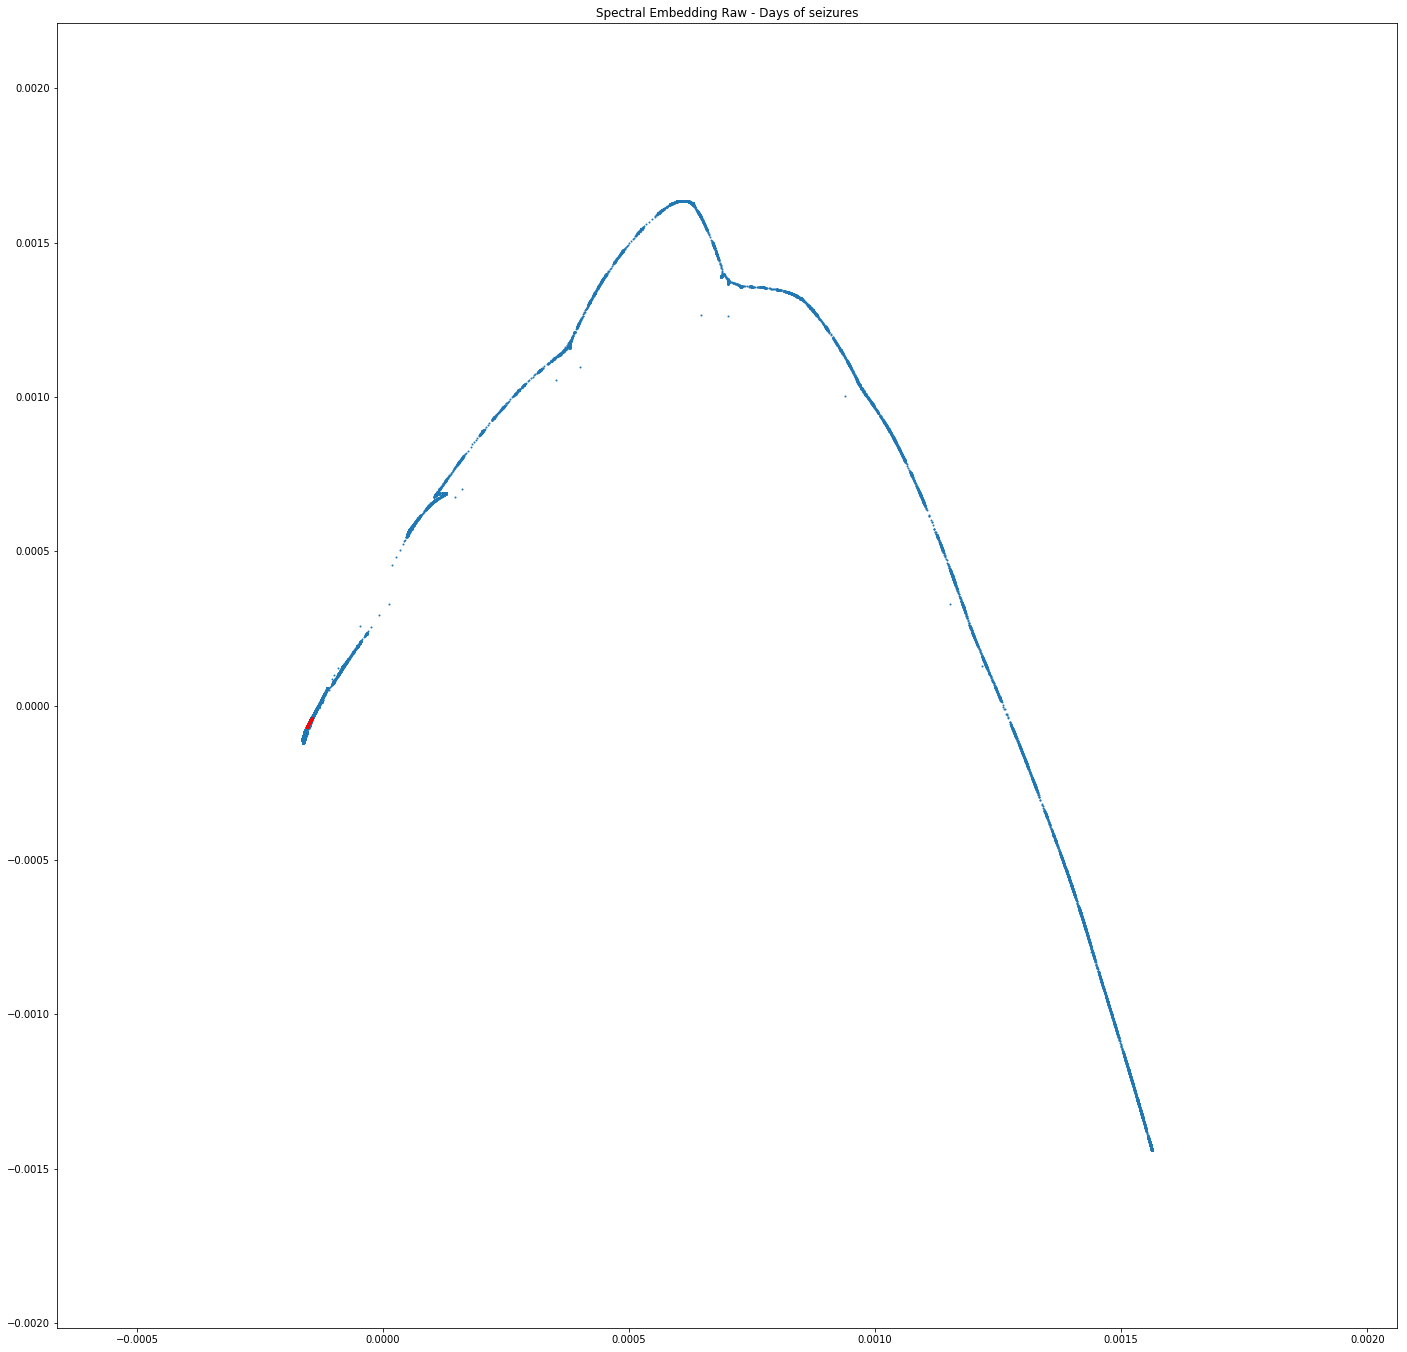

In [12]:
plt.figure(figsize=(24,24))
seSample = seB

target = datosPart['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(seSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('Spectral Embedding Raw - Days of seizures')


## t-SNE

In [6]:
from tsnecuda import TSNE

### Datos Brutos

In [9]:
tsneB = TSNE(n_components=2).fit_transform(data)

Text(0.5, 1.0, 't-SNE Raw - Days of seizures')

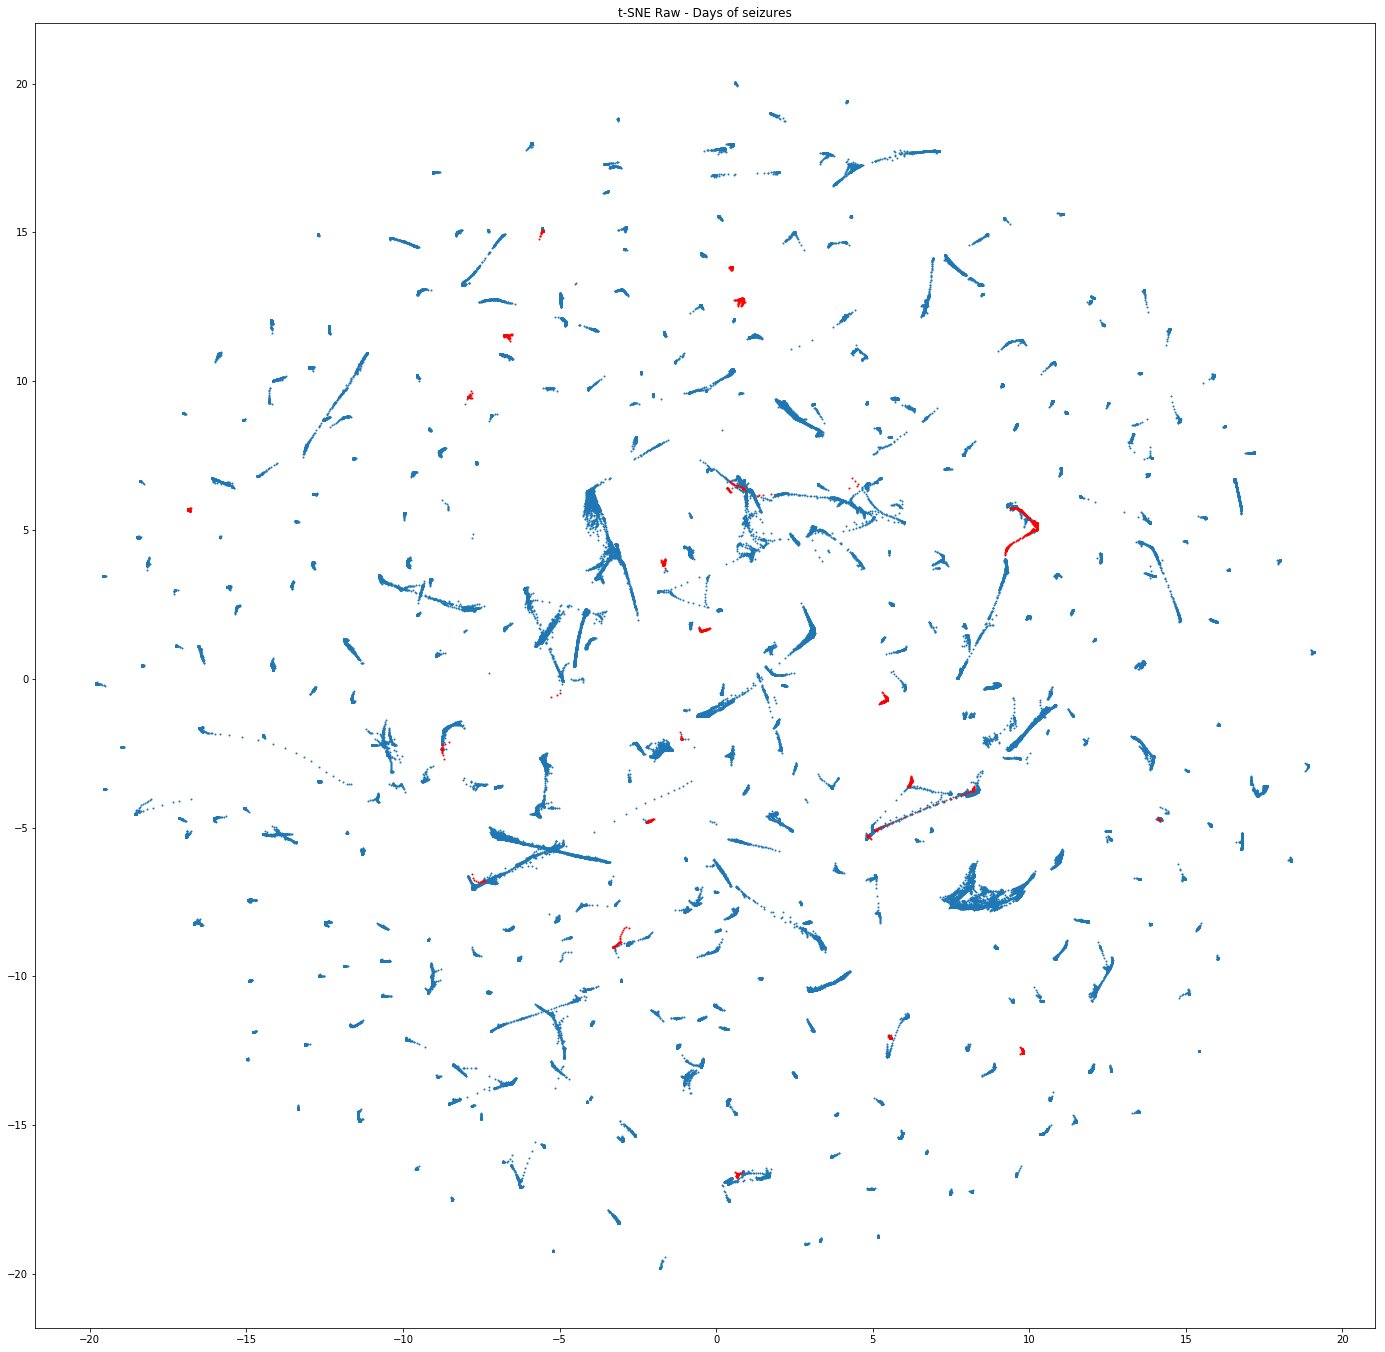

In [10]:
plt.figure(figsize=(24,24))
tsneSample = tsneB

target = datosPart['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(tsneSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('t-SNE Raw - Days of seizures')

## MDS

In [10]:
from sklearn.manifold import MDS

### Datos Brutos

In [11]:
mdsB = MDS(n_components=2,max_iter=100).fit_transform(dataPH)

Text(0.5, 1.0, 'MDS Raw - Days of seizures')

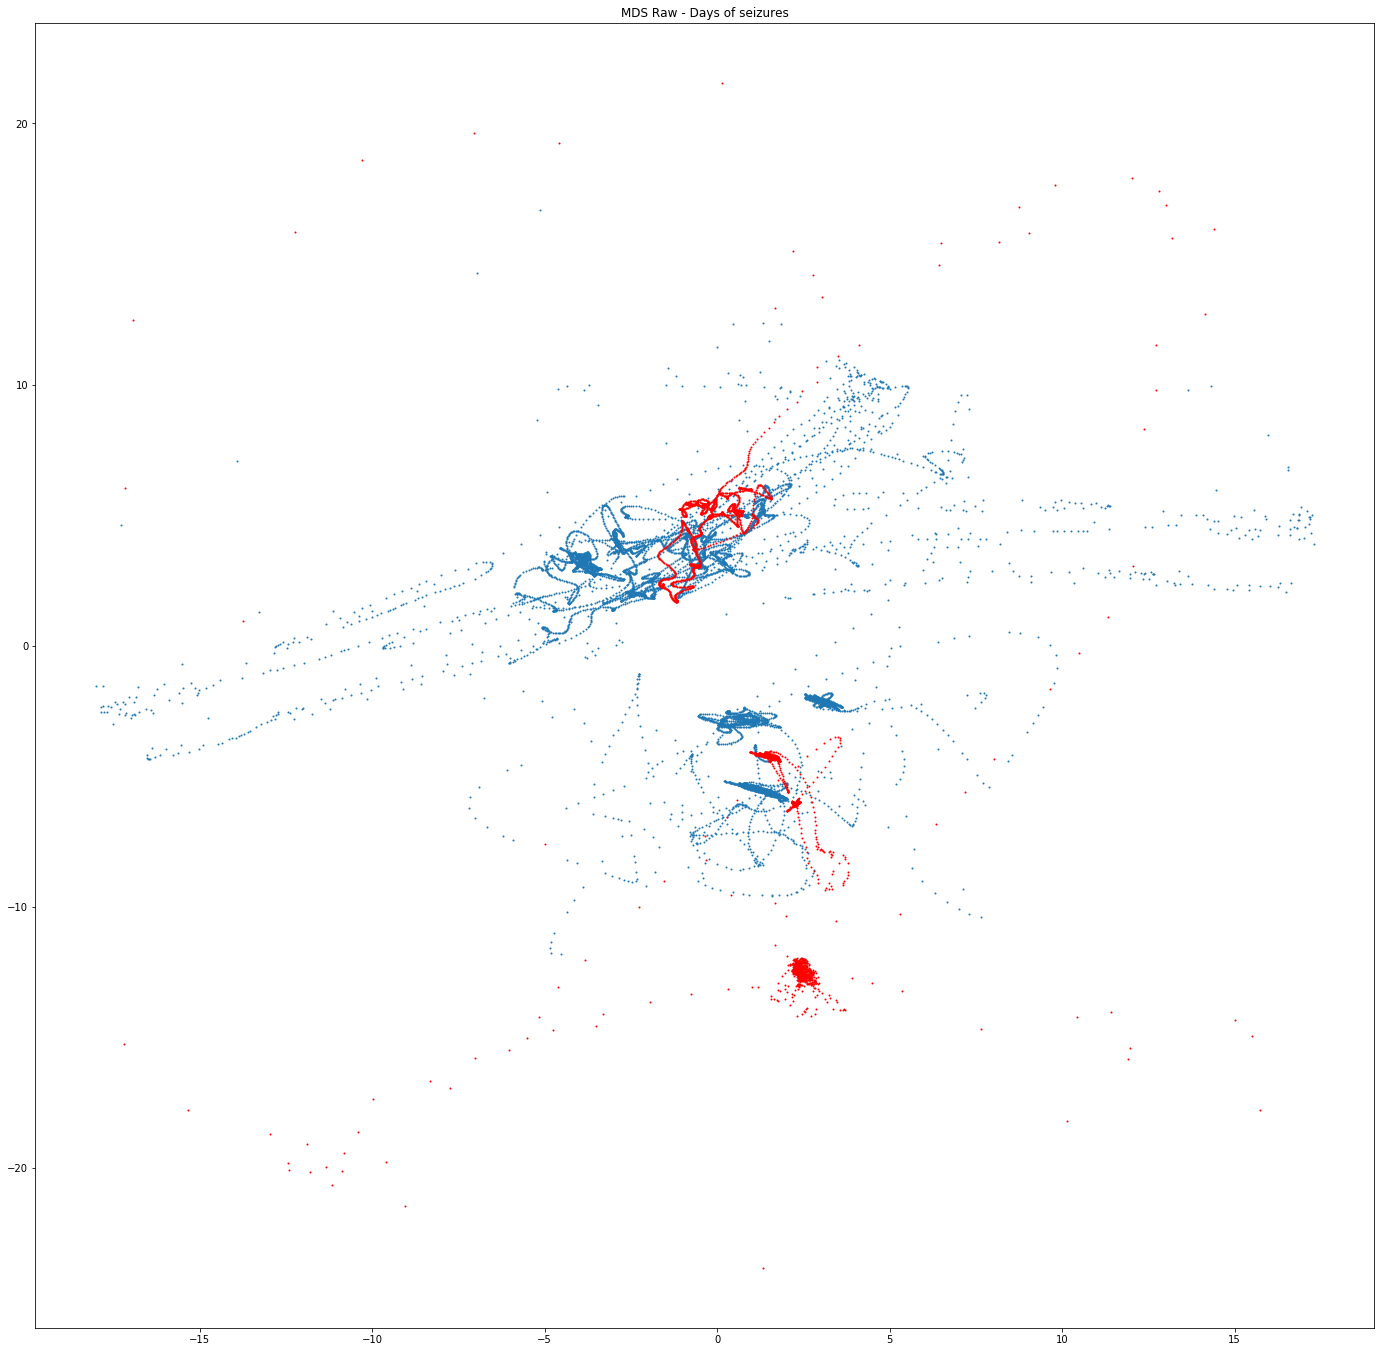

In [13]:
plt.figure(figsize=(24,24))
mdsSample = mdsB

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(mdsSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('MDS Raw - Days of seizures')

## LTSA

In [10]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

### Datos Brutos

In [15]:
ltsaB = LLE(n_components=2,method='ltsa',n_neighbors=10).fit_transform(dataPH)

Text(0.5, 1.0, 'LTSA Raw - Days of seizures')

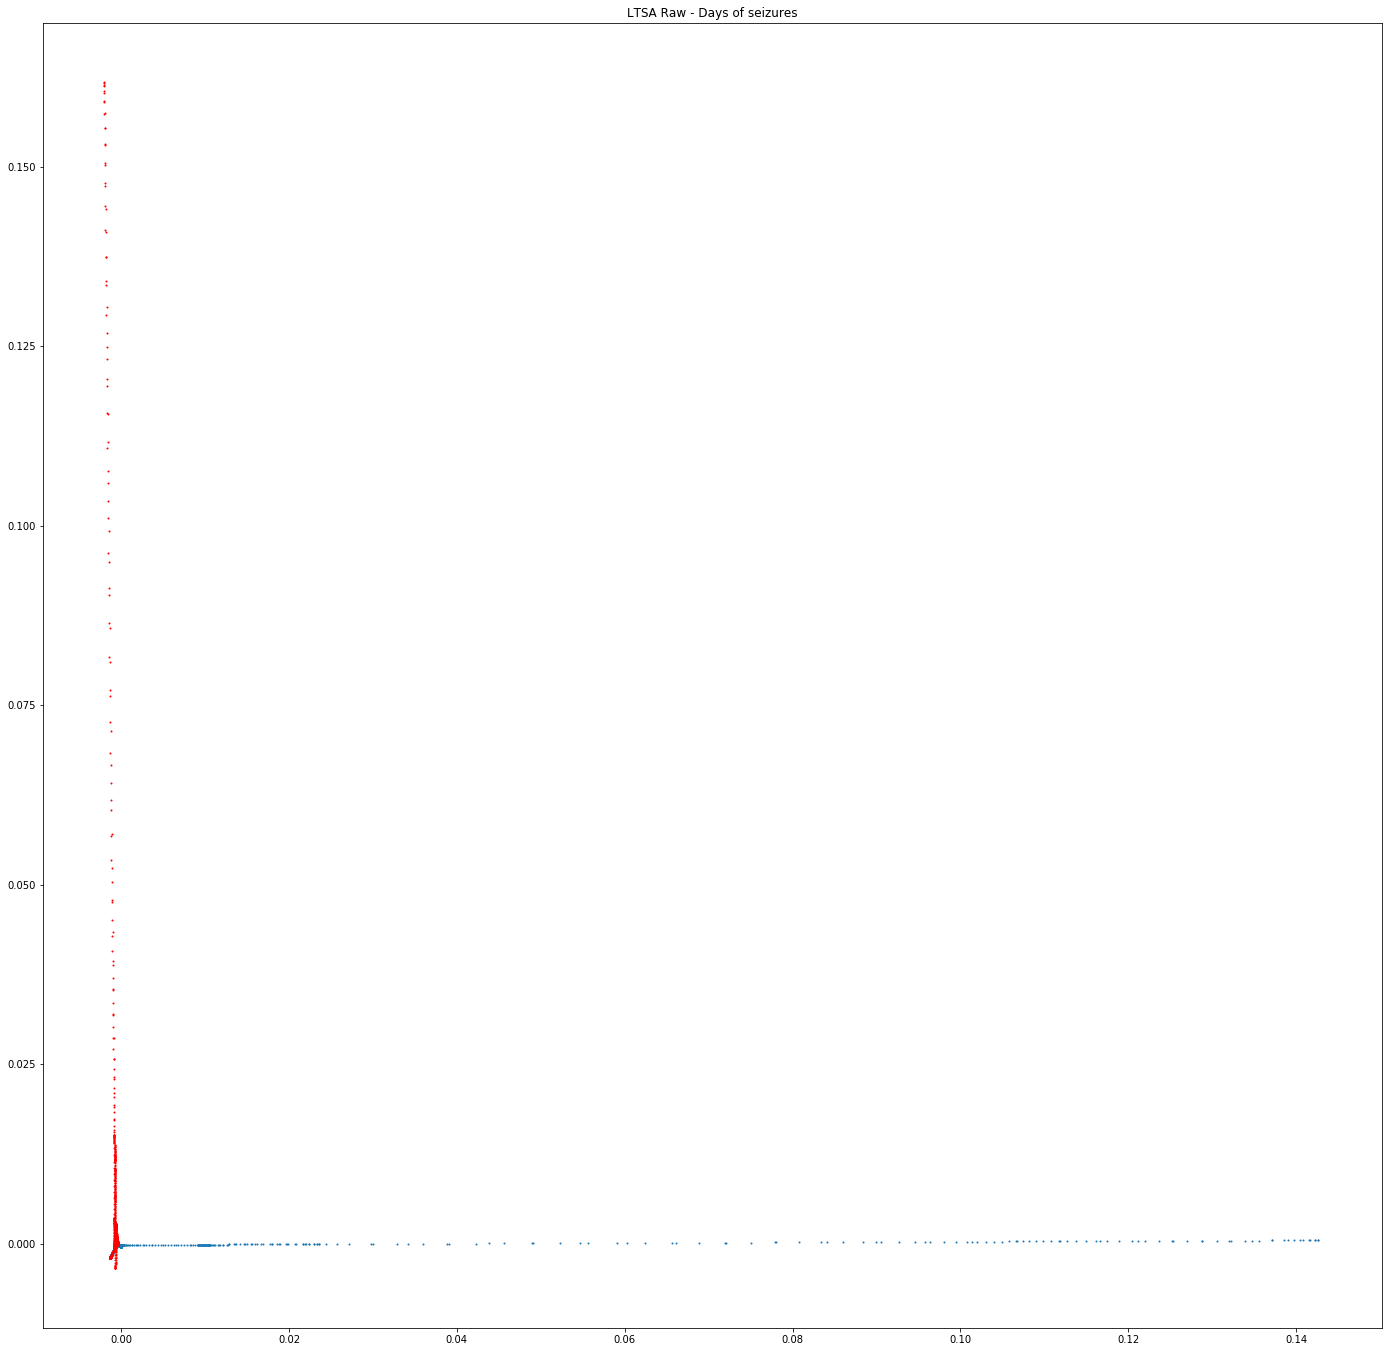

In [18]:
plt.figure(figsize=(24,24))
ltsaSample = ltsaB

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(ltsaSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('LTSA Raw - Days of seizures')